# GET POSSIBLE FISH FROM SEGMENTED WELL

In [584]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import skimage
import cv2 as cv

from skimage import filters, measure, io, segmentation, morphology
from src.well.find_well_props import find_well_props

## Find well props

# Find well props
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Create circle mask for image
_____________________________________________________________
# Creating mask
_____________________________________________________________
# Get bounding box
_____________________________________________________________


Text(0.5, 1.0, 'Mask')

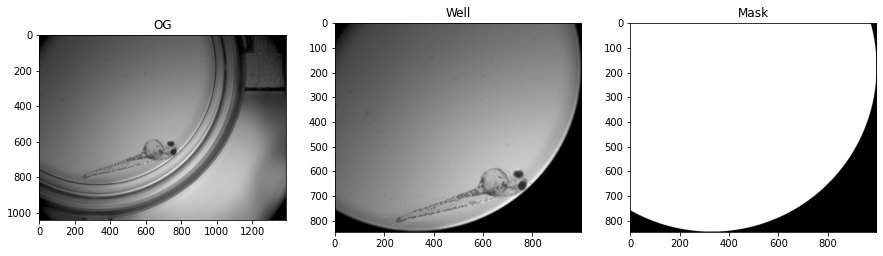

In [585]:
from src.InputImage import InputImage

fishy = InputImage('zf4.jpg')

fishy = find_well_props(fishy)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))

ax[0].imshow(fishy.og, "gray")
ax[0].set_title('OG')

ax[1].imshow(fishy.processed, "gray")
ax[1].set_title('Well')

ax[2].imshow(fishy.well_props.mask.cropped, "gray")
ax[2].set_title('Mask')

## HPF
couldn't seem to find a good homomoprhic filter

is used an implementation of a high pass filter from 'https://www.geeksforgeeks.org/implement-photoshop-high-pass-filter-hpf-using-opencv-in-python/'

then equalized the resulting image

In [586]:
from skimage.morphology import dilation, erosion, square
from skimage.exposure import equalize_hist

(array([109313.,   2197.,   2190.,   2466.,   2380.,   1661.,   2682.,
             0.,   6507.,      0.,      0.,      0.,      0.,      0.,
             0.,  22264.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,  68911.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0., 147519.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

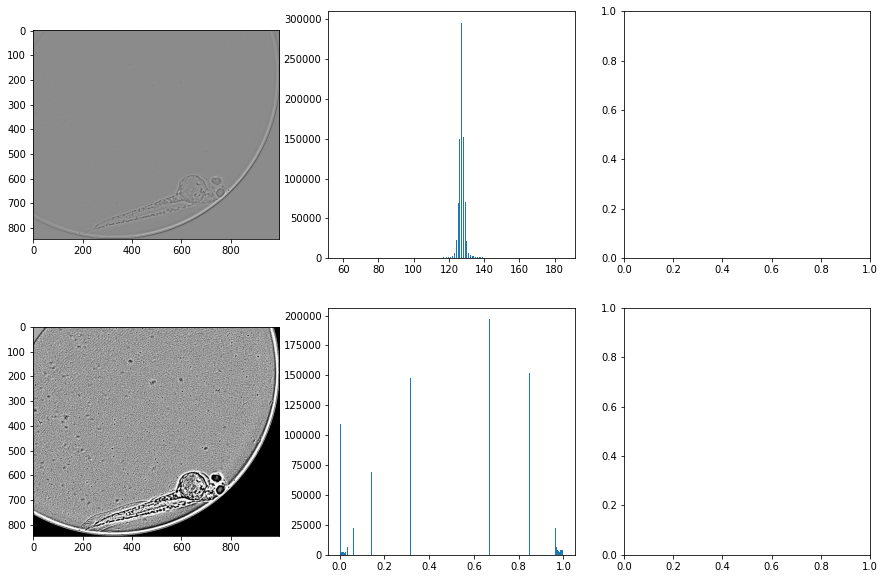

In [587]:
speckless = fishy.well_props.mask.cropped_gray
hpf = speckless - cv.GaussianBlur(speckless, (21, 21), 3) + 127
equalized = equalize_hist(hpf)

equalized = np.multiply(equalized, fishy.well_props.mask.cropped)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

se = square(3)

ax[0, 0].imshow(hpf, 'gray')
ax[0, 1].hist(hpf.ravel(), bins=256)

ax[1, 0].imshow(equalized, 'gray')
ax[1, 1].hist(equalized.ravel(), bins=256)


(array([787912.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

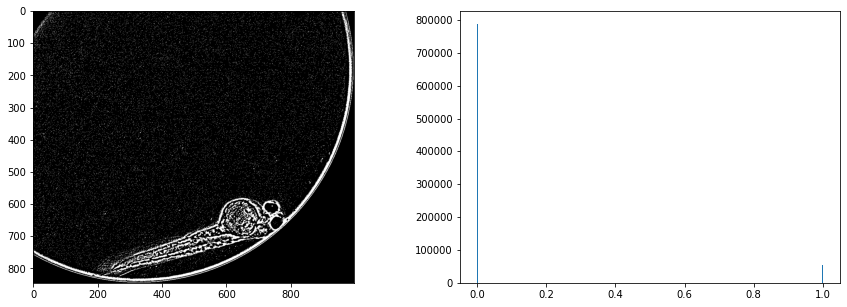

In [588]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

threshed = (equalized > 0.94)

ax[0].imshow(threshed.astype(int), 'gray')
ax[1].hist(threshed.astype(int).ravel(), bins=256)

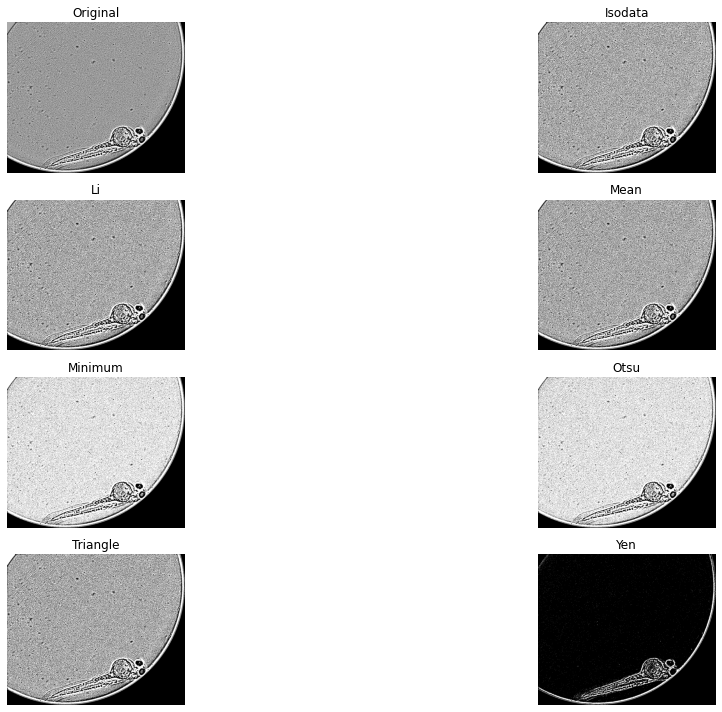

In [589]:
fig, ax = filters.try_all_threshold(equalized, figsize=(20, 10), verbose=False)
plt.show()

## Get the binary thresholded image

Yen thresholding

[[0 0 1 0 0]
 [0 1 1 1 0]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [0 0 1 0 0]]


Text(0.5, 1.0, 'Proc')

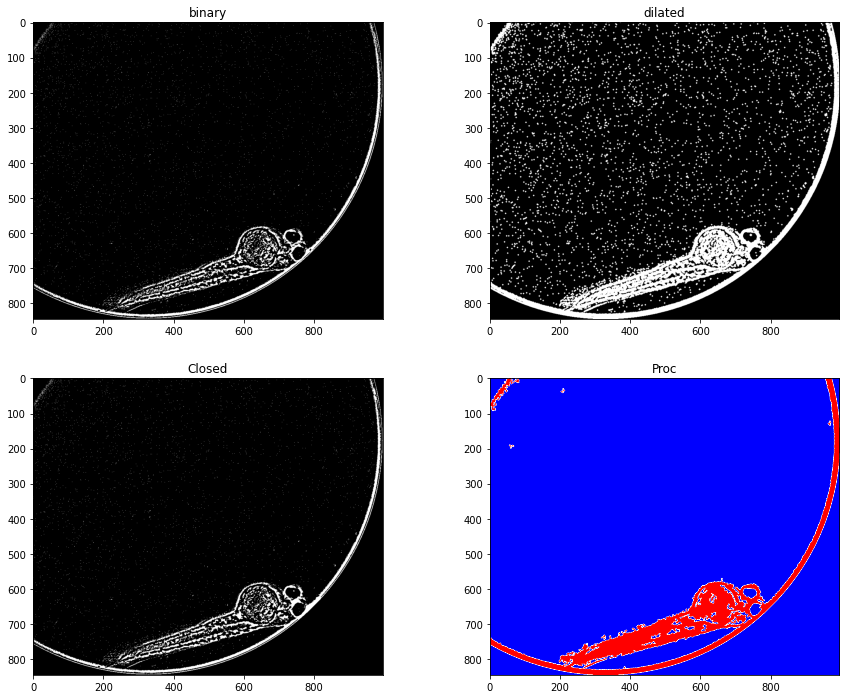

In [590]:
from skimage.segmentation import mark_boundaries
from skimage.filters.edges import sobel
from skimage.morphology import disk, remove_small_objects, remove_small_holes
from skimage.filters.thresholding import threshold_local, threshold_yen

thresh = threshold_yen(equalized)
binary = equalized > thresh
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

se = disk(2)
print(se)

dilated = morphology.binary_dilation(binary, footprint=se)
eroded = morphology.binary_erosion(dilated)

# closed = morphology.binary_closing(binary)
size = fishy.well_props.mask.cropped_gray.size * 0.1
closed = morphology.area_closing(binary, size)

no_speckles = remove_small_objects(remove_small_holes(dilated, connectivity=1, area_threshold=100))

sob = sobel(closed)
mark_b = mark_boundaries(sob, binary)

ax[0, 0].imshow(binary, 'gray')
ax[0, 0].set_title('binary')

ax[0, 1].imshow(dilated, 'gray')
ax[0, 1].set_title('dilated')

ax[1, 0].imshow(closed, 'gray')
ax[1, 0].set_title('Closed')

ax[1, 1].imshow(no_speckles, 'bwr')
ax[1, 1].set_title('Proc')

## Removing specless

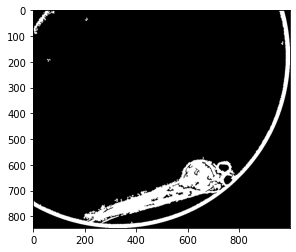

In [602]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.morphology

speckless = no_speckles.copy()

size_th = speckless.size * 0.1

plt.imshow(speckless, 'gray')
plt.show()

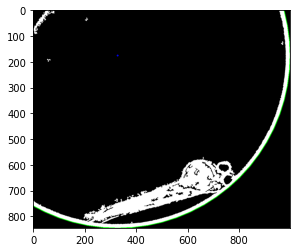

In [619]:
from skimage.color import rgb2gray, gray2rgb

cimg = speckless.copy().astype(int)

cimg = np.uint8(cimg)

cimg = cv.normalize(src=cimg, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
plt.imshow(cimg)

circles = cv.HoughCircles(cimg, cv.HOUGH_GRADIENT, 1.5, 1000, param1=50, param2=30, minRadius=int(fishy.well_props.radius/2), maxRadius=0)


circles = np.uint16(np.around(circles))

meniscus_circle = circles[0, 0]

cimg = gray2rgb(cimg)

for i in circles[0, :]:
    # draw the outer circle
    cv.circle(cimg, (i[0], i[1]), i[2], (0, 255, 0), 2)
    # draw the center of the circle
    cv.circle(cimg, (i[0], i[1]), 2, (0, 0, 255), 3)

plt.imshow(cimg)

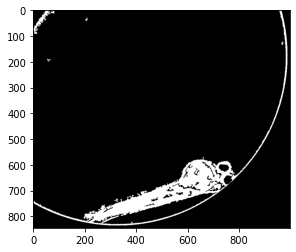

In [622]:
def create_circular_mask(size: tuple[int, int], center: tuple[int, int] = None, radius: int = None) -> np.ndarray:
    if center is None:  # use the middle of the image
        center = (int(size[1] / 2), int(size[0] / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], size[1] - center[0], size[0] - center[1])

    y, x = np.ogrid[:size[0], :size[1]]
    dist_from_center = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)

    return dist_from_center <= radius


well_without_meniscus_mask = create_circular_mask(speckless.shape, (meniscus_circle[0], meniscus_circle[1]),
                                                  meniscus_circle[2] - 10).astype(
    int)  # Radius needs a couple pixel correction because originally

well_without_meniscus = well_without_meniscus_mask * speckless

plt.imshow(well_without_meniscus, "gray")

Max is 38522 @16 index
38522


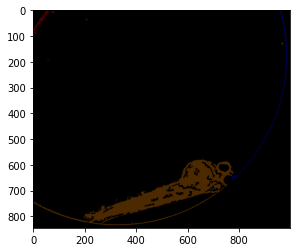

In [623]:
from skimage.measure import regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.morphology import closing, opening
from skimage.segmentation import clear_border

wwmm = erosion(well_without_meniscus, disk(1))

label_image = measure.label(wwmm, connectivity=wwmm.ndim)

label_overlay = label2rgb(label_image, image=wwmm)

props = regionprops_table(label_image, wwmm, properties=["area"])

max_area = max(props["area"])
max_area_index = np.argwhere(props["area"] == max_area)[0][0]

print(f"Max is {max_area} @{max_area_index} index")
largest_region = regionprops(label_image)[max_area_index]


print(largest_region.area)

plt.imshow(label_overlay, "gray")


## Creating mask for fish
After we've found the label with the largest area, we assume it's the fish and get its bbox.

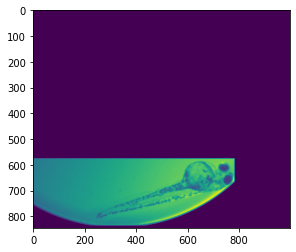

In [624]:
fish_mask = np.zeros_like(wwmm, dtype=int)

x1, y1, x2, y2 = largest_region.bbox

fish_mask[x1:x2, y1:y2] = 1

plt.imshow(fish_mask*fishy.processed)

# FIN
___________________________________________________

In [596]:
def get_mean_col_sum_for_structuring_element(data: np.ndarray, corner: str, corrected_step: bool):  #cont, mod_cont
    thresh_well = np.zeros_like(data.shape)

    col_sum = np.sum(data[-1:1])  # in matlab ->   data'
    mean_data = np.floor(np.mean(col_sum[(col_sum > 0)]))
    """
        if not corrected_step:
            img = cont
        else:
            img = mod_cont
    """
    if not np.isnan(mean_data):
        structuring_element = disk(mean_data)
        if corner == 'lt':
            thresh_well = dilation(
                speckless[0:np.floor(speckless.shape[0] / 2), 0:np.floor(speckless.shape[1] / 2)],
                structuring_element)
        elif corner == 'lb':
            thresh_well = dilation(
                speckless[np.floor(speckless.shape[0] / 2):speckless.shape[0], 0:np.floor(speckless.shape[1] / 2)],
                structuring_element)
        elif corner == 'rt':
            thresh_well = dilation(
                speckless[0:np.floor(speckless.shape[0] / 2), np.floor(speckless.shape[1] / 2):speckless.shape[1]],
                structuring_element)
        elif corner == 'rb':
            thresh_well = dilation(
                speckless[np.floor(speckless.shape[0] / 2):speckless.shape[0],
                np.floor(speckless.shape[1] / 2):speckless.shape[1]],
                structuring_element)

    return thresh_well

In [597]:
def get_plate_width_and_remove_sides(binary: np.ndarray, mask: np.ndarray, corrected=False):
    binary_img = binary
    well_mask = mask

    if binary_img.shape != well_mask.shape:
        raise Exception("Arguments 'binary_img' and 'well_mask' must have equal shape" +
                        f"\n'binary_img': {binary_img.shape} != 'well_mask': {well_mask.shape}")

    possible_well_size_th = np.zeros_like(binary_img)
    remaining_binary_img = binary_img

    if not corrected:
        structuring_element = disk(21)
        eroded_well = erosion(well_mask, structuring_element)
        remaining_binary_img[np.where(eroded_well > 0)] = 0
    #    remaining_binary_img = morphology.area_opening(remaining_binary_img, 100)

    mh, mw = binary_img.shape
    h_center, w_center = int(mh / 2), int(mw / 2)

    lt = remaining_binary_img[0:h_center, 0:w_center]
    lb = remaining_binary_img[h_center:mh, 0:w_center]
    rt = remaining_binary_img[0:h_center, w_center:mw]
    rb = remaining_binary_img[h_center:mh, w_center:mw]

    lt_thresh = get_mean_col_sum_for_structuring_element(lt, "lt", corrected)
    lb_thresh = get_mean_col_sum_for_structuring_element(lb, "lb", corrected)
    rt_thresh = get_mean_col_sum_for_structuring_element(rt, "rt", corrected)
    rb_thresh = get_mean_col_sum_for_structuring_element(rb, "rb", corrected)

    return [lt, rt, lb, rb]

C:\Users\gimesia\.virtualenvs\zebrafish_pipenv-QxNREiAZ\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\gimesia\.virtualenvs\zebrafish_pipenv-QxNREiAZ\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, '')

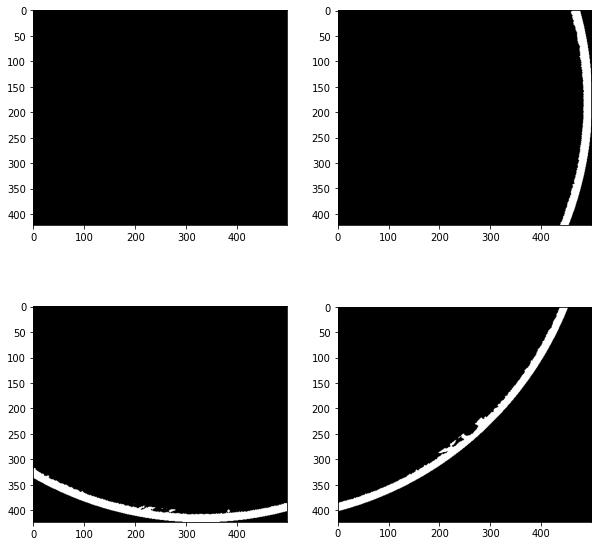

In [598]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

binarey = speckless
mask = fishy.well_props.mask.cropped

a, b, c, d = get_plate_width_and_remove_sides(binarey, mask)

ax[0, 0].imshow(a, 'gray')
ax[0, 0].set_title('')
ax[0, 1].imshow(b, 'gray')
ax[0, 1].set_title('')
ax[1, 0].imshow(c, 'gray')
ax[1, 0].set_title('')
ax[1, 1].imshow(d, 'gray')
ax[1, 1].set_title('')

## Gamma illumination adjustment
Trying to replace homomorphic filter

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

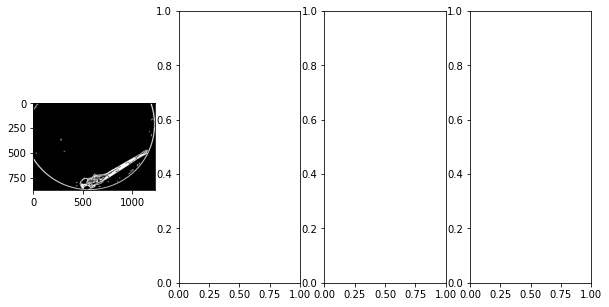

In [599]:
from skimage.exposure import adjust_gamma, adjust_log

data = testie

gamma_low_val = 0.05
gamma_low = adjust_gamma(data, gamma_low_val)

gamma_high_val = 1.2
gamma_high = adjust_gamma(data, gamma=gamma_high_val)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))

ax[0].imshow(gamma_high, 'gray')
ax[1].hist(gamma_high.ravel(), bins=256)
ax[2].imshow(gamma_low, 'gray')
ax[2].set_title('gamma_low')

ax[3].hist(gamma_low.ravel(), bins=256)
ax[3].set_title('gamma_low')

## Gamma illumination adjustment
Trying to replace homomorphic filter

In [ ]:
from skimage.exposure import adjust_gamma, adjust_log

data = fishy.processed

gamma_low_val = 0.05
gamma_low = adjust_gamma(data, gamma_low_val)

gamma_high_val = 1.8
gamma_high = adjust_gamma(data, gamma=gamma_high_val)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

ax[0].imshow(gamma_high, 'gray')
ax[1].hist(gamma_high.ravel(), bins=256)
ax[2].imshow(gamma_low, 'gray')
ax[2].set_title('gamma_low')

ax[3].hist(gamma_low.ravel(), bins=256)
ax[3].set_title('gamma_low')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

image = data.coins()[50:-50, 50:-50]

# apply threshold
thresh = threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(bw)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()